# Atomic models from PDB file

### Imports

Note we use [abtem-legacy](https://github.com/abTEM/abTEM-legacy).

In [2]:
import ase
import abtem
import matplotlib.pyplot as plt

import gemmi
import numpy as np

# scipy utilities
from scipy.ndimage import gaussian_filter, distance_transform_edt, zoom, affine_transform
from scipy.special import erf
from scipy.spatial.transform import Rotation

### PDB to ASE

We use the `gemmi` library to import *.pdb files. 

Note *.pdb files usually only store the asymmetric unit - so instead we download the "biological assembly" file from the [RCSB PDB](https://www.rcsb.org/structure/8RQB), and loop over all symmetrically-equivalent units.

Here, we use the 8rqb record for the apoferritin molecule.

In [3]:
# load PDB file
structure = gemmi.read_pdb("data/8rqb.pdb1")

# initialize xyz coordinates list
xyz_list = []

# loop over biological assemblies
for n_asu in range(len(structure)):
    model = structure[n_asu]
    residues = [res for ch in model for res in ch]
    xyz = np.array([[np.append(atom.pos.tolist(),atom.element.atomic_number) for res in residues for atom in res]])
    xyz_list.append(xyz)

# convert to numpy arraty and reshape
xyz = np.array(xyz_list)
xyz = xyz.reshape((xyz.shape[0],) + xyz.shape[2:])

Note we also appended the atomic number as a 4th column in our dataset:

In [4]:
xyz

array([[[ 55.779,  52.318, 131.426,   7.   ],
        [ 55.913,  52.133, 129.971,   6.   ],
        [ 56.616,  53.317, 129.301,   6.   ],
        ...,
        [ 87.094,  30.354, 114.498,   8.   ],
        [106.709,  40.177, 106.644,   8.   ],
        [ 82.366,  36.78 , 121.039,   8.   ]]])

In [5]:
# convert xyz coordinates in Ang, into an ASE atoms object
pdb_atoms = ase.Atoms(
    numbers= xyz[:,:,3].ravel(),
    positions=xyz[:,:,:3].reshape((-1,3)),
    cell=[256,256,256], # fixed cell-size specification
)

# center atoms in fov
pdb_atoms.center()

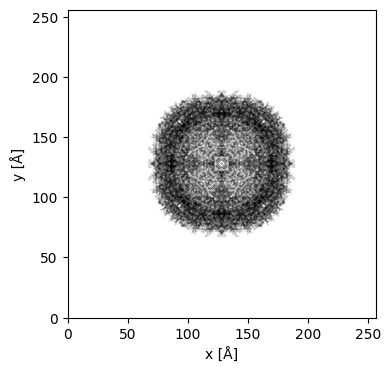

In [55]:
#| label: app:apo_atoms

# visually inspect the apoferritin molecule has been imported correctly
abtem.show_atoms(
    pdb_atoms,
    scale=0.05,
    tight_limits=True,
    figsize=(4,4)
);

### Ice-Embedding

Our protein above is in vacuum. To ensure a more realistic simulation, we can further "embed" the structure in vitreous-ice.

We choose a simple continuum approach, described in Shang and Sigworth continuum water model:  https://doi.org/10.1016/j.jsb.2012.04.021.

Essentially, we "coarse-grain" our protein and compute isosurface distances away from the protein surface - on which we evaluate the continuum expression.

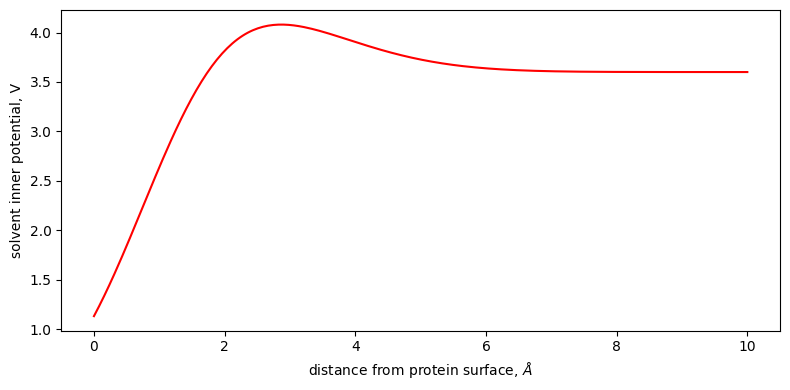

In [54]:
#| label: app:solvent_density_function

def solvent_density_function(r,r1=0.5,r2=1.7,r3=0.7,a2=0.2,a3=-0.15,s1=1,s2=1.77,s3=1.06):
    """ Shang and Sigworth continuum water model:  https://doi.org/10.1016/j.jsb.2012.04.021 """
    return 0.5 + 0.5*erf((r-r1)/np.sqrt(2)/s1) + a2*np.exp(-(r-r2)**2/2/s2**2) + a3*np.exp(-(r-r3)**2/2/s3**2)

r = np.linspace(0,10,256)

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(
    r,
    solvent_density_function(
        r
    )*3.6,
    color='red'
)
ax.set(
    xlabel=r"distance from protein surface, $\AA$",
    ylabel="solvent inner potential, V"
)
fig.tight_layout()

In [57]:
# potential in vacuum
potential = abtem.Potential(
    pdb_atoms,
    slice_thickness=1, # sampling in A
    sampling=(1,1), # sampling in A
).build(
    lazy=False
)

# transposed to xyz
potential_array_xyz = np.ascontiguousarray(potential.array.transpose(1,2,0))

# coarse-grain
potential_array_filtered = gaussian_filter(potential_array_xyz,5)

# compute distance from protein surface 
protein_surface = potential_array_filtered < 2 # note this factor is empirically determined, might need fiddling with
protein_distance = distance_transform_edt(protein_surface)

# evaluate solvent density equation on
solvent_density = solvent_density_function(protein_distance)
embedded_potential_xyz = (solvent_density*3.6) + potential_array_xyz

# make dummy potentials
solvent_density_potential = potential.copy()
solvent_density_potential.array = np.ascontiguousarray(solvent_density.transpose(0,1,2)*3.6,dtype=np.float32)

embedded_potential = potential.copy()
embedded_potential.array = np.ascontiguousarray(embedded_potential_xyz.transpose(0,1,2),dtype=np.float32)

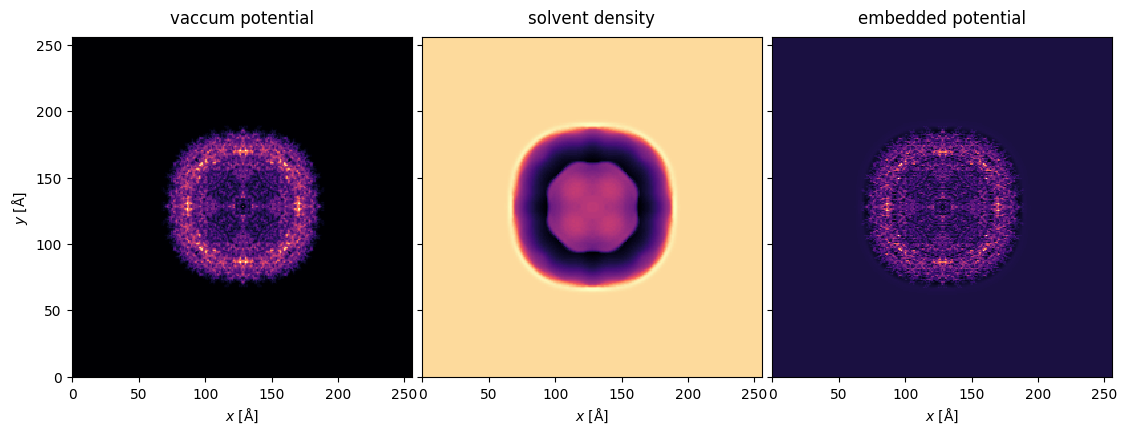

In [107]:
#| label: app:apo_potentials

labels = ("vaccum potential", "solvent density", "embedded potential")
potentials = abtem.stack(
    (potential.project(), solvent_density_potential.project(), embedded_potential.project()),
    labels
)

potentials.show(
    explode=True,
    figsize=(12,4),
    cmap='magma',
    # common_color_scale=True,
    # vmin=-2520 + 256*3.6*2,
    # vmax=2520
);

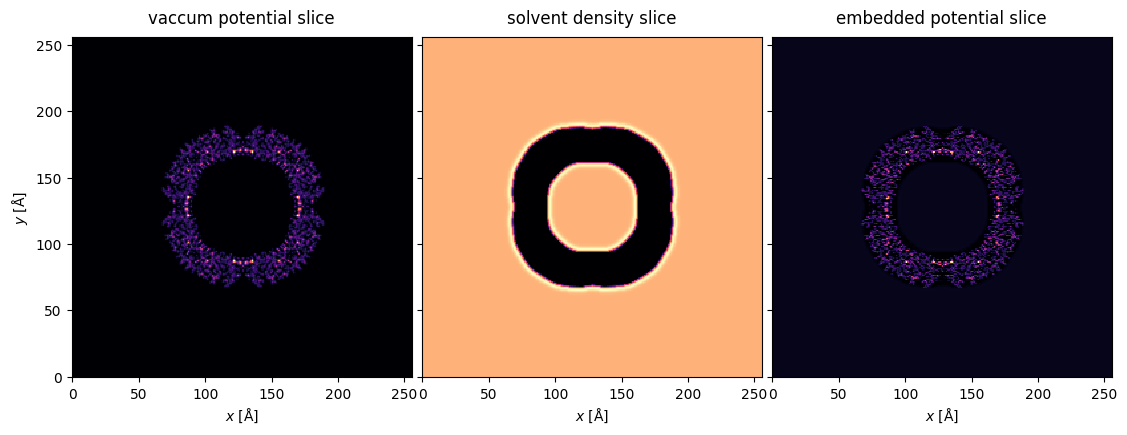

In [108]:
#| label: app:apo_potential_slices

slice_labels = ("vaccum potential slice", "solvent density slice", "embedded potential slice")
potential_slices = abtem.stack(
    (potential[124:132], solvent_density_potential[124:132], embedded_potential[124:132]),
    slice_labels
)

potential_slices.show(
    explode=True,
    figsize=(12,4),
    cmap='magma',
);